### XGBoost Model for the Phishing Websites group project

In [ ]:
%pip install missingno

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import tensorflow as tf
from tensorflow.keras import layers, models

2023-12-08 19:04:08.775485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data = arff.loadarff('Training Dataset.arff')
df = pd.DataFrame(data[0])
df = df.apply(lambda col: col.str.decode('utf-8').str.strip("'"))

df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [10]:
X = df.drop("Result", axis=1)
Y = df['Result']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)

print(X_train.shape)
print(Y_train.shape)

(8844, 30)
(8844,)


# Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation.

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd


X = df.drop("Result", axis=1)
Y = df['Result'].astype(int)  


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Y_train = Y_train.map({-1: 0, 1: 1})
Y_test = Y_test.map({-1: 0, 1: 1})


X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())


param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}


xgb_grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid_xgb,
    cv=10,
    scoring='f1',
    n_jobs=-1
)


xgb_grid_search.fit(X_train, Y_train)


best_model = xgb_grid_search.best_estimator_


xgb_optimal_preds = best_model.predict(X_test)


print("\nXGBoost Test Set Metrics:")
print(classification_report(Y_test, xgb_optimal_preds))
print("ROC-AUC Score:", roc_auc_score(Y_test, xgb_optimal_preds))



XGBoost Test Set Metrics:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       956
           1       0.97      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC-AUC Score: 0.9678241010851989


# list the top 3 features from the trained XGBoost model

In [12]:
feature_importances = best_model.feature_importances_


feature_names = X_train.columns.tolist()


top_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:3]


print("Top 3 Features from XGBoost:")
for rank, (feature, importance) in enumerate(top_features, start=1):
    print(f"{rank}. {feature}: {importance:.4f}")


Top 3 Features from XGBoost:
1. SSLfinal_State: 0.4597
2. URL_of_Anchor: 0.1646
3. Prefix_Suffix: 0.0880


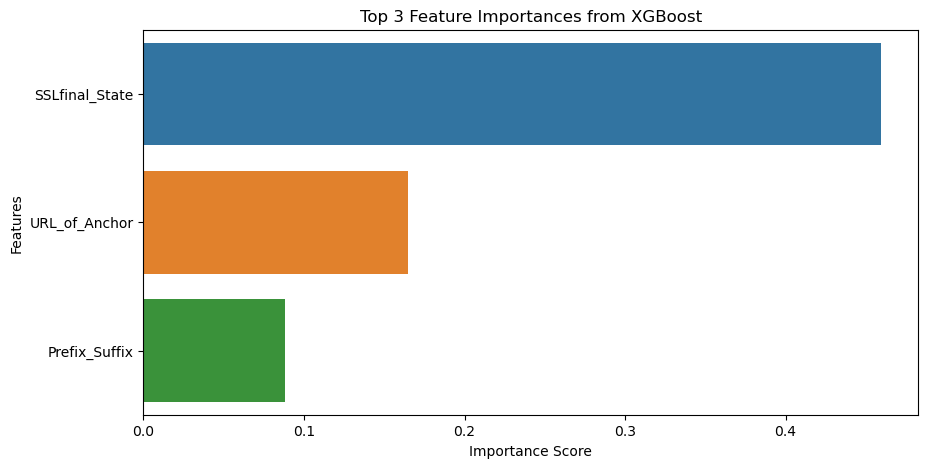

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


top_3_features_xgb = top_features[:3]


features_xgb, importances_xgb = zip(*top_3_features_xgb)


plt.figure(figsize=(10, 5))
sns.barplot(x=list(importances_xgb), y=list(features_xgb))
plt.title("Top 3 Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


### Choose the top 7 features (as given by feature importances from XGBoost) and repeat Training

In [16]:


top_7_features_xgb = top_features[:7]
features_xgb_7, _ = zip(*top_7_features_xgb)


X_train_7 = X_train[list(features_xgb_7)]
X_test_7 = X_test[list(features_xgb_7)]


xgb_optimal_7 = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid_xgb, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

xgb_optimal_7.fit(X_train_7, Y_train)

xgb_optimal_7_best = xgb_optimal_7.best_estimator_


test_preds_7 = xgb_optimal_7_best.predict(X_test_7)


print("Performance Metrics for XGBoost with Top 7 Features:")
print(classification_report(Y_test, test_preds_7))
print("ROC-AUC Score:", roc_auc_score(Y_test, test_preds_7))



Performance Metrics for XGBoost with Top 7 Features:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       956
           1       0.92      0.95      0.94      1255

    accuracy                           0.93      2211
   macro avg       0.93      0.92      0.92      2211
weighted avg       0.93      0.93      0.93      2211

ROC-AUC Score: 0.9218269182683493
